In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
from scipy.stats import qmc
import matplotlib.pyplot as plt

# Função que cria a rede neural
class DNN(nn.Module):
    def __init__(self, in_shape=2, out_shape=1, n_hidden_layers=10, neuron_per_layer=50, actfn=nn.Tanh):
        super(DNN, self).__init__()
        layers = [nn.Linear(in_shape, neuron_per_layer), actfn()]
        for _ in range(n_hidden_layers - 1):
            layers.append(nn.Linear(neuron_per_layer, neuron_per_layer))
            layers.append(actfn())
        layers.append(nn.Linear(neuron_per_layer, out_shape))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Converte numpy arrays para tensor de pytorch
def convert_to_torch_tensors(numpy_arrays):
    return [torch.tensor(array, dtype=torch.float32) for array in numpy_arrays]

In [2]:
# Checar se a gpu sera usada para acelerar o processamento
is_cuda_available = torch.cuda.is_available()

print("Is CUDA (GPU support) available in PyTorch:", is_cuda_available)

Is CUDA (GPU support) available in PyTorch: True


# Diffusion Equation

$$\frac{\partial{u}}{\partial{t}} = D \left[\frac{\partial²{u}}{\partial{r²}} + \frac{1}{r} \frac{\partial{u}}{\partial{r}} + \frac{\partial²{u}}{\partial{\theta²}}\right] $$

$$\frac{\partial{u}}{\partial{t}} = D \left[\frac{\partial²{u}}{\partial{r²}} + \frac{1}{r} \frac{\partial{u}}{\partial{r}}\right] $$

$$\frac{\partial{u}}{\partial{t}} - D \left[\frac{\partial²{u}}{\partial{r²}} + \frac{1}{r} \frac{\partial{u}}{\partial{r}}\right] =0$$


## Initial conditions

$$t = 0 \rightarrow u(r,\theta,0) = \delta(r,\theta)$$

## Boundary conditions

$$u(r,θ,t)=0$$

# Data Generation

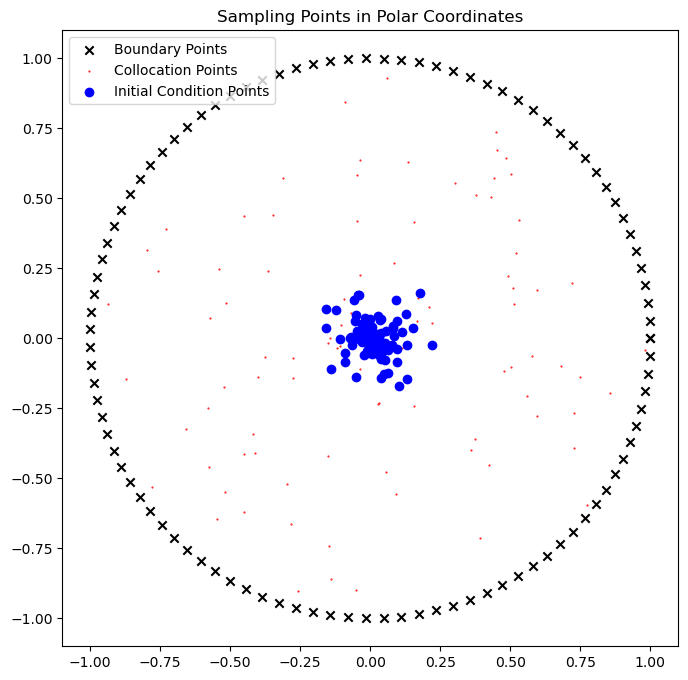

In [3]:
# Example parameters
R = 1.0  # Radius of the domain
N_boundary = 100  # Number of boundary points
N_colloc = 100   # Number of collocation points
N_init = 100      # Number of initial condition points

# Sampling time steps
t_start = 0 # Tempo inicial
t_end = 1    # Tempo final
N_time = 100  # Number of time points

t_points = np.linspace(t_start, t_end, N_time)

# Defining initial concentration values
threshold_radius = 0.1  # Example value, adjust based on your setup

# Sampling boundary points (on the circle)
theta_boundary = np.linspace(0, 2 * np.pi, N_boundary)
r_boundary = np.full_like(theta_boundary, R)
boundary_concentration = 0  # Adjust based on your problem


# Convert to Cartesian for visualization
x_boundary = r_boundary * np.cos(theta_boundary)
y_boundary = r_boundary * np.sin(theta_boundary)

# Sampling collocation points
theta_colloc = np.random.uniform(0, 2 * np.pi, N_colloc)
r_colloc = np.random.uniform(0, R, N_colloc)

# Convert to Cartesian for visualization
x_colloc = r_colloc * np.cos(theta_colloc)
y_colloc = r_colloc * np.sin(theta_colloc)

# Sampling initial condition points (near the origin)
r_init = np.random.normal(0, 0.1, N_init)  # Small radius values
theta_init = np.random.uniform(0, 2 * np.pi, N_init)

# Convert to Cartesian for visualization
x_init = r_init * np.cos(theta_init)
y_init = r_init * np.sin(theta_init)

# Calculate the distance of each initial point from the source
distances = np.sqrt(x_init**2 + y_init**2)  # Convert tensors to np arrays if they are not already

# Assign high concentration (e.g., 1) to points within the threshold radius, and 0 elsewhere
initial_concentration_values = np.where(distances <= threshold_radius, 1.0, 0.0)

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(x_boundary, y_boundary, c='k', marker='x', label='Boundary Points')
plt.scatter(x_colloc, y_colloc, s=1, c='r', marker='.', label='Collocation Points')
plt.scatter(x_init, y_init, c='b', marker='o', label='Initial Condition Points')
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Sampling Points in Polar Coordinates")
plt.legend()
plt.show()

# converter pontos iniciais para tensores
t = torch.tensor(t_points, dtype=torch.float32).unsqueeze(1)
theta_boundary = torch.tensor(theta_boundary, dtype=torch.float32).unsqueeze(1)
r_boundary = torch.tensor(r_boundary, dtype=torch.float32).unsqueeze(1)
theta_colloc = torch.tensor(theta_colloc, dtype=torch.float32).unsqueeze(1)
r_colloc = torch.tensor(r_colloc, dtype=torch.float32).unsqueeze(1)
theta_init = torch.tensor(theta_init, dtype=torch.float32).unsqueeze(1)
r_init = torch.tensor(r_init, dtype=torch.float32).unsqueeze(1)
u_init = torch.tensor(initial_concentration_values, dtype=torch.float32).unsqueeze(1)
t_d = torch.full((r_boundary.shape[0], 1), boundary_concentration, dtype=torch.float32)

# Defining functions

In [4]:
def u(model,t, x):
    # Combinar x e y em um unico tensor de input
    inputs = torch.cat([t, x], dim=1)
    # Forward pass pelo modelo
    u = model(inputs)
    return u

In [5]:
def f(model, D, t, x):
    # Garantir que x e y precisem de gradiente
    x.requires_grad_(True)
#     y.requires_grad_(True)
    t.requires_grad_(True)

    # computar u0
    u0 = u(model, t, x)

    # Primeiras derivadas
    u_x = torch.autograd.grad(u0, x, grad_outputs=torch.ones_like(u0), create_graph=True)[0]
#     u_y = torch.autograd.grad(u0, y, grad_outputs=torch.ones_like(u0), create_graph=True)[0]
    u_t = torch.autograd.grad(u0, t, grad_outputs=torch.ones_like(u0), create_graph=True)[0]
    
    # Segundas derivadas
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
#    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
#     u_zz = torch.autograd.grad(u_z, z, grad_outputs=torch.ones_like(u_z), create_graph=True)[0]

    # Computar F
    F = u_t - D*(u_xx + (1/x)*u_x)

    # Retorna erro quadrado médio
    return torch.mean(F ** 2)

In [6]:
def initial_condition_loss(model, x_init, u_init):
    # Predict concentration at initial points
    u_predicted = u(model, x_init, u_init)

    # Compute the loss (MSE) between predicted and actual initial concentration
    loss_ic = torch.mean((u_predicted - u_init) ** 2)
    return loss_ic

In [7]:
def mse(y, y_):
    return torch.mean((y - y_) ** 2)

# Training model

In [8]:
print("t shape:", t.shape)
print('u_init:', u_init.shape)
print("r_boundary shape:", r_boundary.shape)
print("theta_boundary shape:", theta_boundary.shape)

t shape: torch.Size([100, 1])
u_init: torch.Size([100, 1])
r_boundary shape: torch.Size([100, 1])
theta_boundary shape: torch.Size([100, 1])


    0, 0.598
  200, 0.254
  400, 0.125
  600, 0.112
  800, 0.107
  999, 0.102

computation time: 12.328



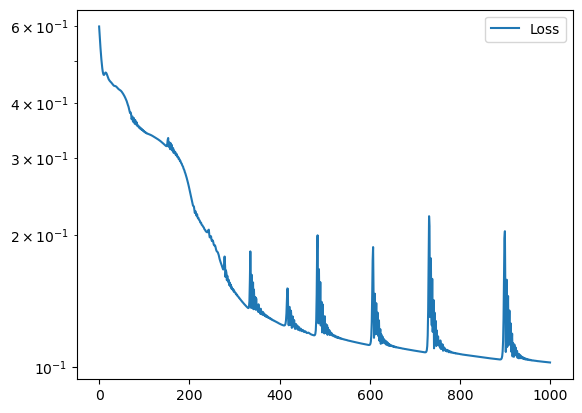

In [9]:
model = DNN()  # Modelo de rede neural que aproximara a função. 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # Otimizador Adam.

epochs = 1000
loss_values = []
D = 1
start = time.time()

for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass por u e f
    T_ = u(model, t, r_boundary)
    L = f(model, D, t, r_colloc)
    l = mse(t_d, T_)
    
    # Initial condition loss
    l_ic = initial_condition_loss(model, r_init, u_init)

    # Loss total
    loss = l + L + l_ic

    # Passo de backpropagation
    loss.backward()

    # Atualizar pesos
    optimizer.step()

    # Gravar loss
    loss_values.append(loss.item())

    if epoch % 200 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss.item():.3f}")

end = time.time()
computation_time = {}
computation_time['pinn'] = end - start
print(f"\ncomputation time: {end - start:.3f}\n")

# Plotar o erro
plt.semilogy(loss_values, label='Loss')
plt.legend()
plt.show()

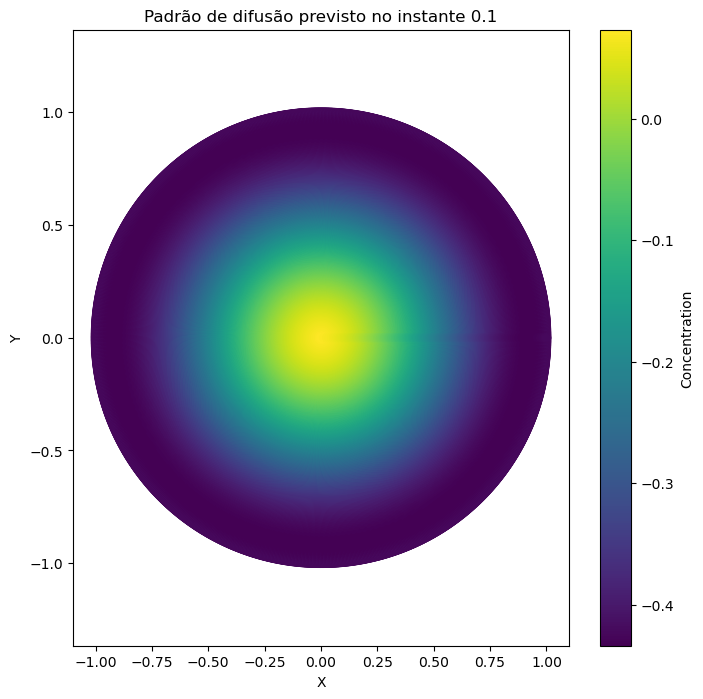

In [13]:
# Step 1: Choose a specific time step for visualization
time_step = .1  # Example time step, adjust as needed

# Step 2: Generate a grid of points in polar coordinates with time
r_values = np.linspace(0, 1, 1000)  # Adjust as needed
theta_values = np.linspace(0, 2 * np.pi, 1000)
r_grid, theta_grid = np.meshgrid(r_values, theta_values)

# Flatten the grid for model input
r_flat = r_grid.flatten()
theta_flat = theta_grid.flatten()

# Assign the chosen time step to each point
t_flat = np.full_like(r_flat, time_step)

# Convert to tensors
r_tensor = torch.tensor(r_flat, dtype=torch.float32).unsqueeze(1)
theta_tensor = torch.tensor(theta_flat, dtype=torch.float32).unsqueeze(1)
t_tensor = torch.tensor(t_flat, dtype=torch.float32).unsqueeze(1)

# Step 3: Predict concentration
with torch.no_grad():  # No need to track gradients here
    u_pred = u(model, t_tensor, r_tensor).numpy()

# Step 4: Plot the results
x_pred = r_flat * np.cos(theta_flat)
y_pred = r_flat * np.sin(theta_flat)

# Visualization
plt.figure(figsize=(8, 8))
plt.scatter(x_pred, y_pred, c=-u_pred, cmap='viridis')
plt.colorbar(label='Concentration')
plt.title(f'Padrão de difusão previsto no instante {time_step}')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.savefig('diff_00.png')
plt.show()

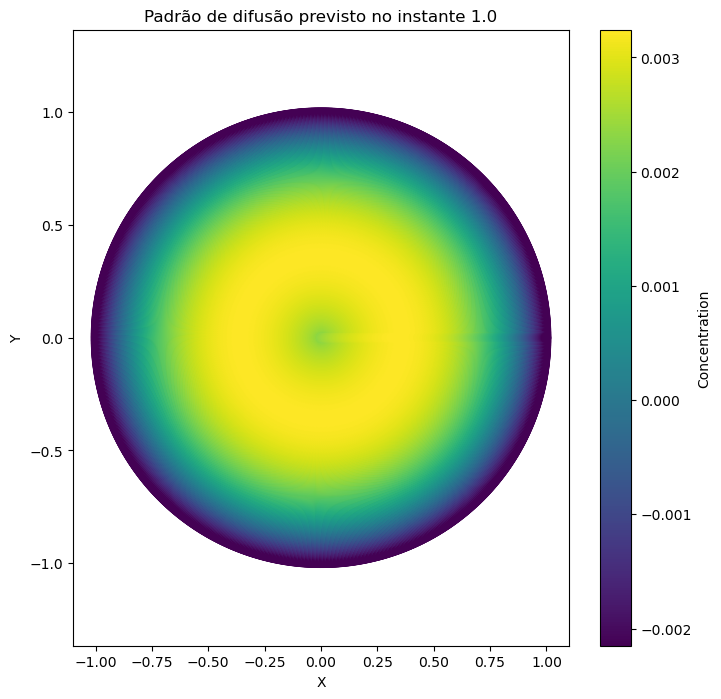

In [14]:
# Step 1: Choose a specific time step for visualization
time_step = 1.  # Example time step, adjust as needed

# Step 2: Generate a grid of points in polar coordinates with time
r_values = np.linspace(0, 1, 1000)  # Adjust as needed
theta_values = np.linspace(0, 2 * np.pi, 1000)
r_grid, theta_grid = np.meshgrid(r_values, theta_values)

# Flatten the grid for model input
r_flat = r_grid.flatten()
theta_flat = theta_grid.flatten()

# Assign the chosen time step to each point
t_flat = np.full_like(r_flat, time_step)

# Convert to tensors
r_tensor = torch.tensor(r_flat, dtype=torch.float32).unsqueeze(1)
theta_tensor = torch.tensor(theta_flat, dtype=torch.float32).unsqueeze(1)
t_tensor = torch.tensor(t_flat, dtype=torch.float32).unsqueeze(1)

# Step 3: Predict concentration
with torch.no_grad():  # No need to track gradients here
    u_pred = u(model, t_tensor, r_tensor).numpy()

# Step 4: Plot the results
x_pred = r_flat * np.cos(theta_flat)
y_pred = r_flat * np.sin(theta_flat)

# Visualization
plt.figure(figsize=(8, 8))
plt.scatter(x_pred, y_pred, c=-u_pred, cmap='viridis')
plt.colorbar(label='Concentration')
plt.title(f'Padrão de difusão previsto no instante {time_step}')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.savefig('diff_01.png')
plt.show()

In [12]:
# torch.save(model, 'diffusion_eq.pth')